In [2]:
from data_pipeline import data_creation, preprocessing, dataset_order
from models.mlp_model import MLP
from models.kan_model import KANWrapper
from models.train_test import train_model
import torch

In [4]:
df = data_creation.create_time_series(5000, ["trend", "seasonality"], noise=True, scale=0.3)
X, y = preprocessing.create_windows(df, input_len=100, pred_len=14)
X_train, X_test, y_train, y_test = dataset_order.split_dataset(X, y)

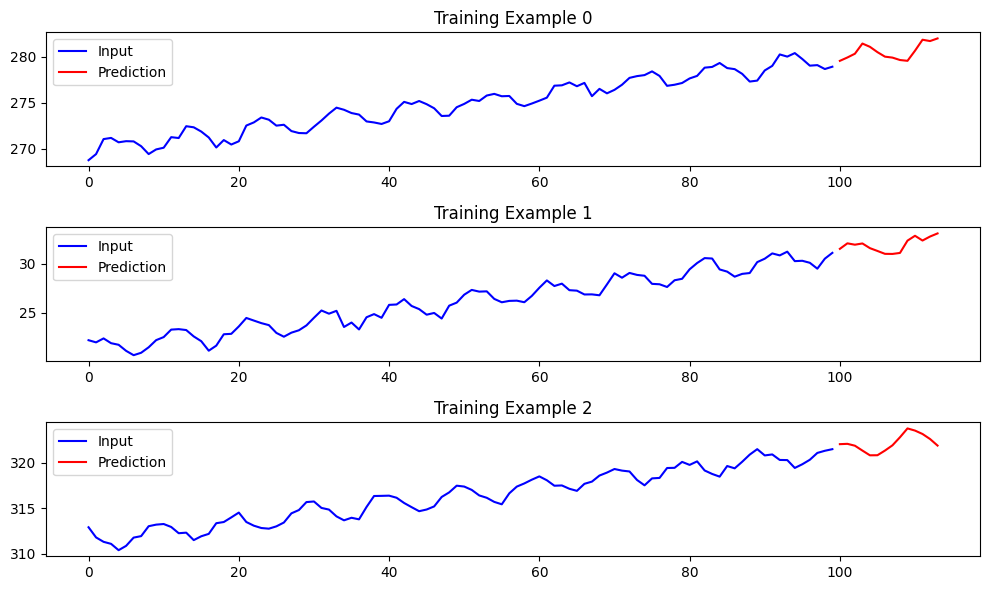

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i in range(3):
    x_vals = X_train[i]
    y_vals = y_train[i]

    if not hasattr(y_vals, '__len__'):
        y_vals = [y_vals]

    input_x = list(range(len(x_vals)))
    pred_x = list(range(len(x_vals), len(x_vals) + len(y_vals)))

    axs[i].plot(input_x, x_vals, color='blue', label='Input')

    axs[i].plot(pred_x, y_vals, color='red', label='Prediction')

    axs[i].set_title(f"Training Example {i}")
    axs[i].legend()

plt.tight_layout()
plt.show()

In [10]:
mlp_model = MLP([X.shape[1], 128, 128, 128, y.shape[1]])
train_model(mlp_model, X_train, y_train, X_test, y_test, name="mlp")

[mlp] Epoch   0 | Train Loss: 87627.5078 | Test Loss: 81925.8359
[mlp] Epoch  10 | Train Loss: 32750.5098 | Test Loss: 22954.1641
[mlp] Epoch  20 | Train Loss: 1734.7928 | Test Loss: 604.1954
[mlp] Epoch  30 | Train Loss: 1800.7639 | Test Loss: 1581.5939
[mlp] Epoch  40 | Train Loss: 415.6103 | Test Loss: 409.7082
[mlp] Epoch  50 | Train Loss: 183.6663 | Test Loss: 221.0131
[mlp] Epoch  60 | Train Loss: 117.5491 | Test Loss: 110.0681
[mlp] Epoch  70 | Train Loss: 42.3778 | Test Loss: 29.0121
[mlp] Epoch  80 | Train Loss: 12.5583 | Test Loss: 14.3715
[mlp] Epoch  90 | Train Loss: 12.4480 | Test Loss: 12.1763
[mlp] Epoch  99 | Train Loss: 8.7554 | Test Loss: 8.6723


MLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=14, bias=True)
  )
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.74e-01 | test_loss: 7.77e-01 | reg: 1.20e+02 | : 100%|█| 100/100 [33:34<00:00, 20.14


saving model version 0.1
Pruning...
saving model version 0.2
Plotting splines...


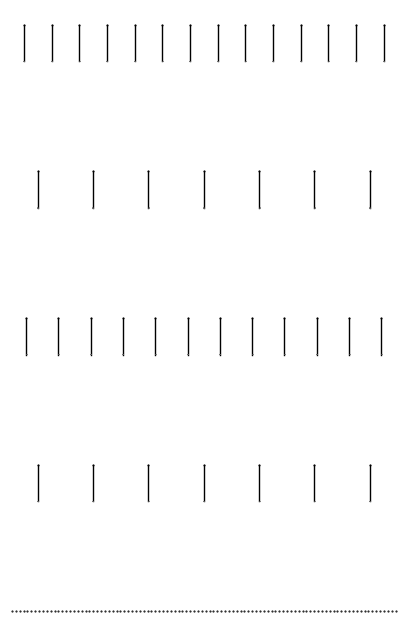

In [ ]:
kan_model = KANWrapper(width=[X.shape[1], 5, 5, 5, y.shape[1]], grid=5)
kan_model.model.fit(
    dataset={
        'train_input': torch.tensor(X_train, dtype=torch.float32),
        'train_label': torch.tensor(y_train, dtype=torch.float32),
        'test_input': torch.tensor(X_test, dtype=torch.float32),
        'test_label': torch.tensor(y_test, dtype=torch.float32)
    },
    opt='LBFGS',
    steps=100,
    lamb=0.01,
    update_grid=True, grid_update_num=6,
    lamb_entropy=5., lamb_coef=0.1
)

print("Pruning...")
kan_model.model = kan_model.model.prune()


print("Plotting splines...")
kan_model(torch.tensor(X_test, dtype=torch.float32))
kan_model.model.plot()

In [31]:
from sympy import symbols
import torch

# 1. Forward pass required
kan_model(torch.tensor(X_test[:1], dtype=torch.float32))


# 3. Extract symbolic formula
input_vars = symbols(f'x0:{X.shape[1]}')
formulas = kan_model.model.symbolic_formula(var=input_vars)
print(formulas[0][0])

0
